In [126]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853

### Plotting code

In [144]:
def plotTimeSeries(t, y, LS_xlim=None,title=None):
    frequency, power = LombScargle(t,y).autopower()
    
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax00 = fig.add_subplot(gs[0, :])
    ax00.plot(t, y)
    ax00.set_xlabel('time')
    ax00.set_ylabel('signal')
    if title is not None:
        ax00.set_title('{0} time series'.format(title))
    else:
        ax00.set_title('time series')

    ax10 = fig.add_subplot(gs[1, 0])
    ax10.hist(y,bins=30)
    ax10.set_xlabel('signal')
    ax10.set_ylabel('count')
    ax10.set_title('Histogram')


    ax11 = fig.add_subplot(gs[1, 1])
    ax11.plot(frequency, power)
    ax11.set_xlabel('frequency')
    ax11.set_ylabel('power')
    ax11.set_title('Lomb-Scargle periodogram')
    if LS_xlim is not None:
        ax11.set_xlim(LS_xlim)

    plt.show()
    return 

### Gaussian noise, multi-periodic signal, and Rossler signal

In [145]:
# multi-periodic signal from Kovacs & Buchler 1988
def KB88(t,a1=1.0,a2=0.6,a3=0.2,v1=0.1,v2=0.048,v3=0.0252):
    w1 = 2*np.pi*v1
    w2 = 2*np.pi*v2
    w3 = 2*np.pi*v3
    
    # length t + 1
    t2 = np.append(t, t[-1] + np.mean(t[1:] - t[0:-1]))
    
    r = a1 * np.cos(w1 * t2) + a2 * np.cos(w2 * t2) + a3 * np.cos(w3 * t2) \
        + 0.5 * a1 * a3 * (np.cos( (w1 + w3) * t2) + np.cos( (w1 - w3) * t2)) \
        + 0.1 * a2 * a3 * (np.cos( (w2 + w3) * t2) + np.cos( (w2 - w3) * t2)) \
        + 0.1 * a1 * a2 * (np.cos( (w1 + w2) * t2) + np.cos( (w1 - w2) * t2)) \
        + 0.1 * a1**2 * np.cos(2. * w1 * t2) \
        + 0.1 * a2**2 * np.cos(2. * w2 * t2)
    
    v = (r[1:] - r[0:-1])/np.mean(t[1:] - t[0:-1])
        
    return r[:-1], v

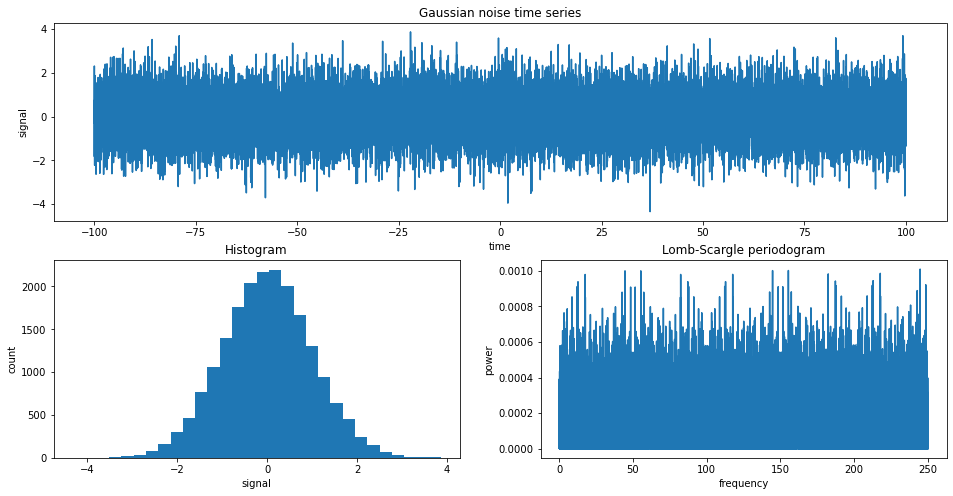

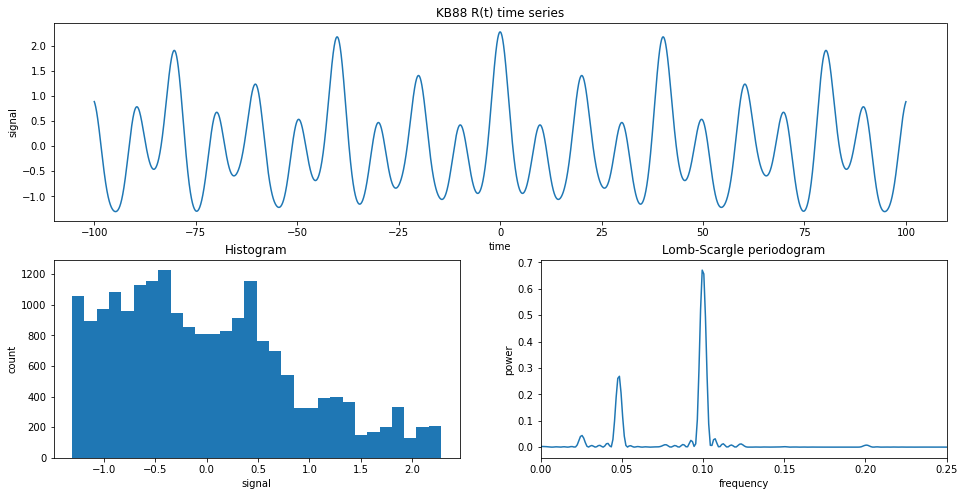

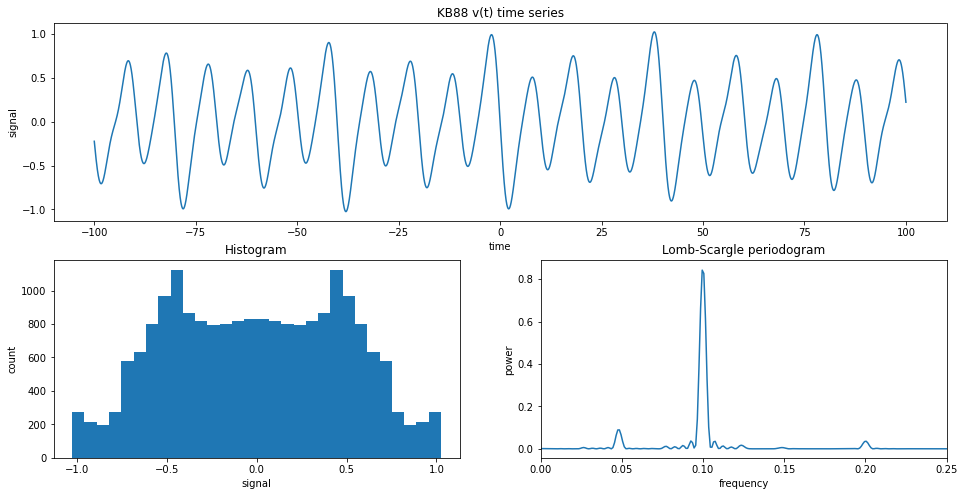

In [146]:
np.random.seed(8421)

dt = 0.01
t = np.arange(-100,100,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
plotTimeSeries(t, gaussianNoise,title="Gaussian noise")


multiPeriodic_r, multiPeriodic_v = KB88(t)
plotTimeSeries(t, multiPeriodic_r, LS_xlim = (0.,0.25),title="KB88 R(t)")
plotTimeSeries(t, multiPeriodic_v, LS_xlim = (0.,0.25),title="KB88 v(t)")

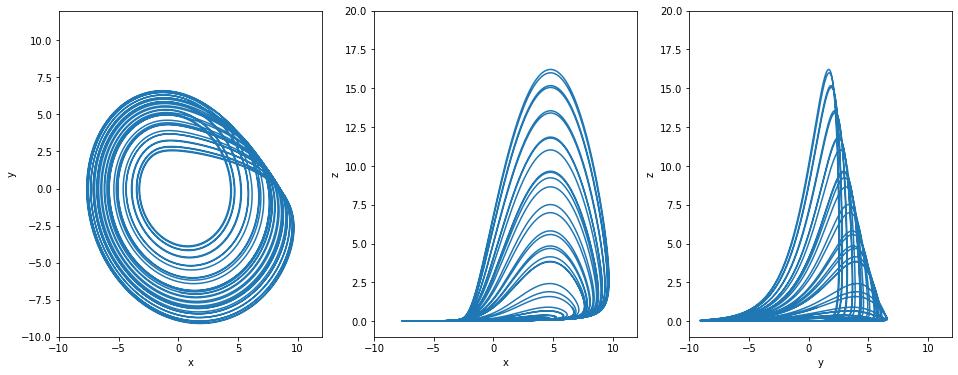

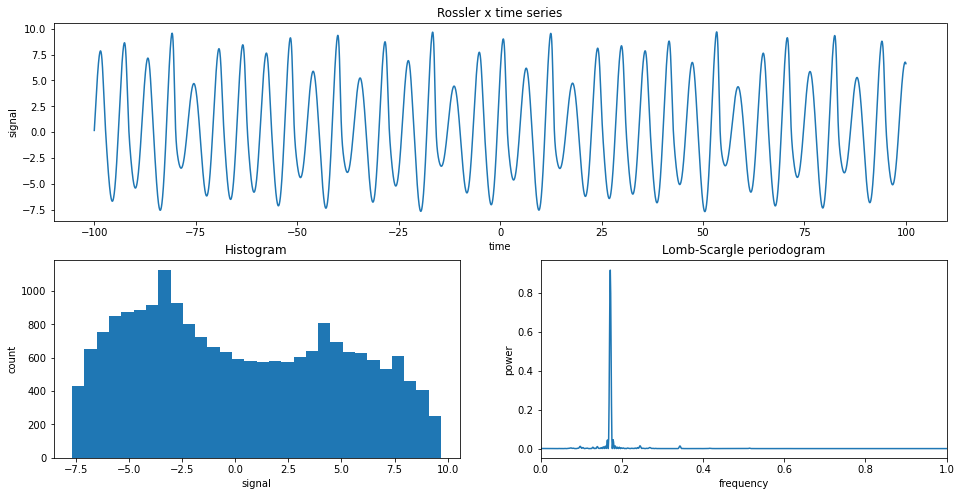

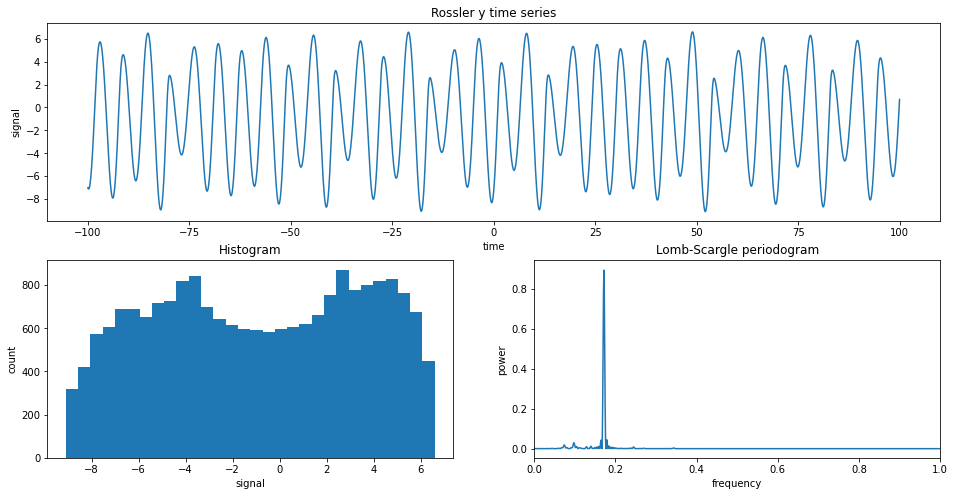

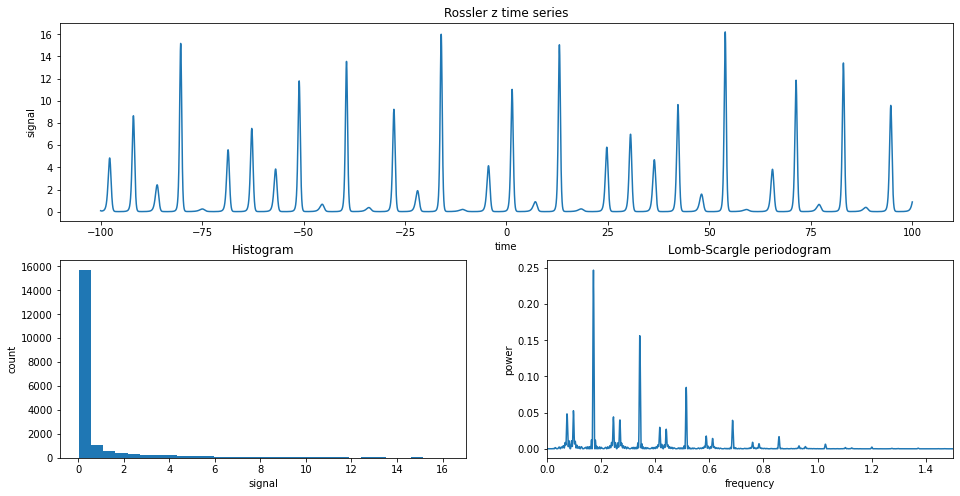

In [154]:
r0 = np.array((0.1, -7, 0.1))

def Rossler_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    a=0.2
    b=0.2
    c=4.8
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = -y - z
    v_y = x + a*y
    v_z = b + z*(x - c)
    
    return np.array((v_x, v_y, v_z))


rossler = RK45(fun=Rossler_vel,t0=0.,y0=r0,max_step=0.01,t_bound=100000.)

N = len(t)

rossler_r = np.empty((N,3))
for i in range(N):
    rossler.step()
    rossler_r[i] = rossler.y


fig, axes = plt.subplots(1,3,figsize=(16,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1])
axes[0].set_xlim(-10,12)
axes[0].set_ylim(-10,12)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2])
axes[1].set_xlim(-10,12)
axes[1].set_ylim(-1,20)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2])
axes[2].set_xlim(-10,12)
axes[2].set_ylim(-1,20)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(t,rossler_r[:,0],LS_xlim=(0.,1.),title="Rossler x")
plotTimeSeries(t,rossler_r[:,1],LS_xlim=(0.,1.),title="Rossler y")
plotTimeSeries(t,rossler_r[:,2],LS_xlim=(0.,1.5),title="Rossler z")

# old/didn't work

In [117]:
def leapfrog(r0, v0, dt, N, acceleration_func, args=()):
    '''
    lambda keyword basically clones acceleration_func; now 'func(x)' will return 'acceleration_func(x, *args)'. 
    this way,the specific acceleration_func can be an argument to leapfrog().
    
    r0 is (n_dim)
    v0 is (n_dim)
    N = number of steps
    
    Return:
    r_array = array of positions at all timesteps. shape: (n_steps, n_dimensions)
    v_array = array of velocities at all timesteps. shape: (n_steps, n_dimensions)
    '''
    func = lambda x: acceleration_func(x, *args)
    
    #initialize output arrays
    r0_arr = np.atleast_1d(r0)
    ndim = r0_arr.shape[0]

    r_array = np.zeros((N, ndim))
    v_array = np.zeros((N, ndim))
    
    r_array[0] = r0
    v_array[0] = v0
    
    #initial acceleration
    a0 = func(r0)
    #initialize v by stepping to 1/2dt
    v1_2 = v0 + a0*(dt/2)
    
    #leapfrog steps: we want to get position and velocity at every integer time step
    for i in range(1, N):
        r1 = r0 + v1_2*dt
        #print("r1 is {0}".format(r1))
        a1 = func(r1)
        #print("a1 is {0}".format(a1))
        v1 = v1_2 + a1*(dt/2)
        v3_2 = v1 + a1*(dt/2)
        #print("v1 is {0}".format(v1))
        r_array[i] = r1
        v_array[i] = v1
        r0, v1_2 = r1, v3_2
        
    return r_array, v_array


# Rossler system, coefficients same as Serre + 1996b
def Rossler_vel(r, a=0.2, b=0.2, c=4.8):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = -y - z
    v_y = x + a*y
    v_z = b + z*(x - c)
    
    return np.array((v_x, v_y, v_z))
    
def Rossler_accel(r, a=0.2, b=0.2, c=4.8):
    """
    r is an array (x, y, z)
    return xdoubledot, ydoubledot, zdoubledot
    """
    x = r[0]
    y = r[1]
    z = r[2]
    
    a_x = -x - a*y - b - z*(x - c)
    a_y = -y - z + a*x + a**2 * y
    a_z = b*x - b*c + z*((x - c)**2) - z*y - z**2
    
    return np.array((a_x, a_y, a_z))

rossler_r, rossler_v = leapfrog(r0=r0, v0=Rossler_vel(r0), dt=0.000005, N=100*len(t), acceleration_func=Rossler_accel)
